# Stability maps in Rebound

In what follows, I try to make a stability map for HD 202206 system using `rebound`. I, earlier, ran a MCMC analysis of the system -- the initial parameter of this system is taken from this analysis. This work is largely following the tutorial in [this](https://rebound.readthedocs.io/en/latest/ipython_examples/Megno/) documentation of `rebound`. The chaos indicator used here is MEGNO (Mean Exponential Growth of Nearby Orbits), with the symplectic integrator WHFast (Rein and Tamayo 2015).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import rebound
from rebound.interruptible_pool import InterruptiblePool

In [2]:
# Planetary and stellar parameters
NBpl = int(2) 
mstar = 0.9985
mEarth = 3.986004e14 / 1.3271244e20 # mEarth expressed in mSun

a_b = 0.7930
p_b = 256.2056
lambda_b = 2.65316226  # REBOUND uses angles in radians, in [-pi;pi] 
e_b = 0.42916
w_b = 2.80615782 # REBOUND uses angles in radians, in [-pi;pi] 
i_b = 0.0
O_b = 0.0
m_b = 0.015182 # In mSun

a_c =  2.3962
p_c = 1355.0
lambda_c = -3.05781685
e_c = 0.1596
w_c = 1.43466065 
i_c = 0.0 
O_c = 0.0 
m_c = 0.002220 # In mSun

In [3]:
def simulation(par):
    global mstar, m_b, m_c, a_b, a_c, lambda_b, lambda_c, w_b, w_c, e_b, e_c
    a, e = par # unpack parameters
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.ri_whfast.safe_mode = 0
    sim.dt = 5.
    sim.add(m=mstar) # Star
    sim.add(m=m_b, a=a_b, l=lambda_b, omega=w_b, e=e_b, Omega=O_b, inc=i_b)
    sim.add(m=m_c, a=a, l=lambda_c, omega=w_c, e=e, Omega=O_c, inc=i_c)
    sim.move_to_com()
    
    sim.init_megno()
    sim.exit_max_distance = 20. 
    try:
        sim.integrate(1e4*2.*np.pi, exact_finish_time=0) # integrate for 500 years, integrating to the nearest
        #timestep for each output to keep the timestep constant and preserve WHFast's symplectic nature
        megno = sim.calculate_megno() 
        return megno
    except rebound.Escape:
        return 10. # At least one particle got ejected, returning large MEGNO.

def pbpc(ac):
    """
    A function to find period ratio
    using Kepler's third law
    """
    global a_b
    pc = ((ac/a_b)**1.5)
    return pc

In [4]:
Ngrid = 80
par_a = np.linspace(2.16,2.48,Ngrid)
par_e = np.linspace(0.,0.5,Ngrid)
parameters = []
for e in par_e:
    for a in par_a:
        parameters.append((a,e))

pool = InterruptiblePool()
results = pool.map(simulation,parameters)

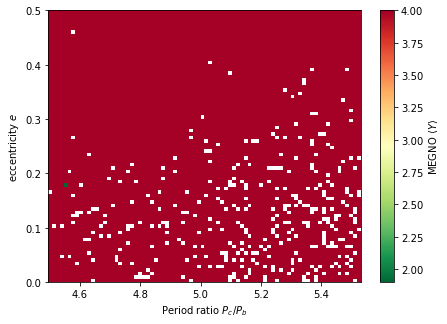

In [5]:
results2d = np.array(results).reshape(Ngrid,Ngrid)
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
extent = [pbpc(min(par_a)), pbpc(max(par_a)), min(par_e), max(par_e)]
ax.set_xlim(extent[0],extent[1])
ax.set_xlabel("Period ratio $P_c/P_b$")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel("eccentricity $e$")
im = ax.imshow(results2d, interpolation="none", vmin=1.9, vmax=4, cmap="RdYlGn_r", origin="lower", aspect='auto', extent=extent)
cb = plt.colorbar(im, ax=ax)
cb.set_label("MEGNO $\\langle Y \\rangle$")